In [ ]:
pip install requests pandas matplotlib numpy scipy

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize

def fetch_earthquake_data(start_date, end_date, min_magnitude=None, latitude_min=None, latitude_max=None, longitude_min=None, longitude_max=None):
    """
    ดึงข้อมูลแผ่นดินไหวจาก USGS API
    """
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query?"
    params = {
        "format": "geojson",
        "starttime": start_date,
        "endtime": end_date,
    }

    if min_magnitude:
        params["minmagnitude"] = min_magnitude
    if latitude_min and latitude_max:
        params["minlatitude"] = latitude_min
        params["maxlatitude"] = latitude_max
    if longitude_min and longitude_max:
        params["minlongitude"] = longitude_min
        params["maxlongitude"] = longitude_max

    response = requests.get(base_url, params=params)
    response.raise_for_status()  # ตรวจสอบว่ามีข้อผิดพลาด HTTP หรือไม่
    data = response.json()

    earthquakes = []
    for feature in data['features']:
        properties = feature['properties']
        geometry = feature['geometry']
        earthquakes.append({
            'time': pd.to_datetime(properties['time'], unit='ms'),
            'magnitude': properties['mag'],
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2]
        })
    return pd.DataFrame(earthquakes)

# กำหนดช่วงวันที่และขอบเขตของประเทศไทย (โดยประมาณ)
start_date = "2010-05-25"
end_date = "2025-05-25"
# ขอบเขตของประเทศไทยโดยประมาณ
thailand_lat_min, thailand_lat_max = 5.0, 21.0
thailand_lon_min, thailand_lon_max = 97.0, 106.0

print(f"กำลังดึงข้อมูลแผ่นดินไหวในประเทศไทย ตั้งแต่วันที่ {start_date} ถึง {end_date}...")
eq_data = fetch_earthquake_data(
    start_date,
    end_date,
    min_magnitude=1.0,  # กำหนด magnitude ขั้นต่ำเพื่อกรองข้อมูล
    latitude_min=thailand_lat_min,
    latitude_max=thailand_lat_max,
    longitude_min=thailand_lon_min,
    longitude_max=thailand_lon_max
)

# จัดเรียงข้อมูลตามเวลา
eq_data = eq_data.sort_values(by='time').reset_index(drop=True)

print(f"ดึงข้อมูลแผ่นดินไหวได้ทั้งหมด {len(eq_data)} รายการ")
print("ตัวอย่างข้อมูล:")
print(eq_data.head())

กำลังดึงข้อมูลแผ่นดินไหวในประเทศไทย ตั้งแต่วันที่ 2010-05-25 ถึง 2025-05-25...
ดึงข้อมูลแผ่นดินไหวได้ทั้งหมด 84 รายการ
ตัวอย่างข้อมูล:
                     time  magnitude  latitude  longitude  depth
0 2010-09-19 08:58:17.870        4.0    20.233    105.039   10.0
1 2010-12-30 18:50:19.100        4.8    20.865    103.419   10.0
2 2011-02-23 15:53:16.270        4.6    18.915    101.727   10.0
3 2011-03-24 13:55:12.010        6.9    20.687     99.822    8.0
4 2011-03-24 14:23:53.000        4.8    20.655     99.930   11.1


กำลังดึงข้อมูลแผ่นดินไหวในประเทศไทย ตั้งแต่วันที่ 2010-05-25 ถึง 2025-05-25...
ดึงข้อมูลแผ่นดินไหวได้ทั้งหมด 84 รายการ
ตัวอย่างข้อมูล:
                     time  magnitude  latitude  longitude  depth
0 2010-09-19 08:58:17.870        4.0    20.233    105.039   10.0
1 2010-12-30 18:50:19.100        4.8    20.865    103.419   10.0
2 2011-02-23 15:53:16.270        4.6    18.915    101.727   10.0
3 2011-03-24 13:55:12.010        6.9    20.687     99.822    8.0
4 2011-03-24 14:23:53.000        4.8    20.655     99.930   11.1

ค่า Mc ที่คำนวณด้วยวิธี Maximum Curvature: 4.55


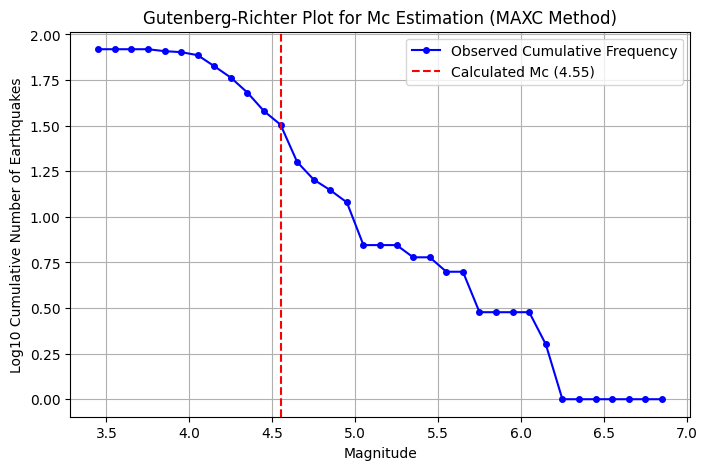


จำนวนแผ่นดินไหวที่ใช้ในการวิเคราะห์ ETAS (Magnitude >= 4.55): 32 รายการ
ช่วงเวลาการวิเคราะห์: 4385.66 วัน

กำลังประมาณค่าพารามิเตอร์ ETAS ด้วย MLE...

การประมาณค่าพารามิเตอร์ ETAS เสร็จสมบูรณ์:
  mu (อัตราแผ่นดินไหวพื้นหลัง): 0.0048 เหตุการณ์/วัน
  A (Productivity): 0.0327
  alpha (Productivity scaling): 2.0860
  c (Omori law constant): 0.6259 วัน
  p (Omori law exponent): 3.2733
  b (Gutenberg-Richter b-value): 1.0000
  Negative Log-Likelihood: 137.0511


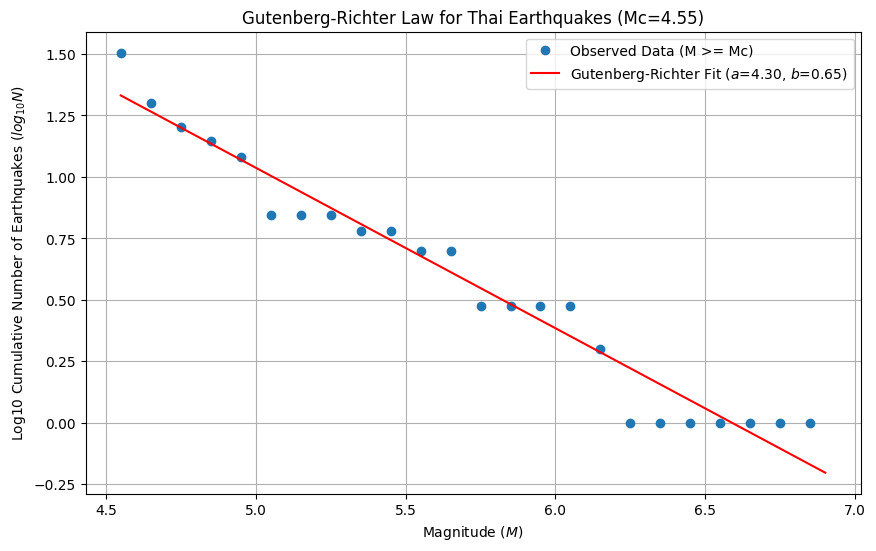


พารามิเตอร์ Gutenberg-Richter ที่ได้จากการฟิต (สำหรับ M >= Mc): a=4.30, b=0.65


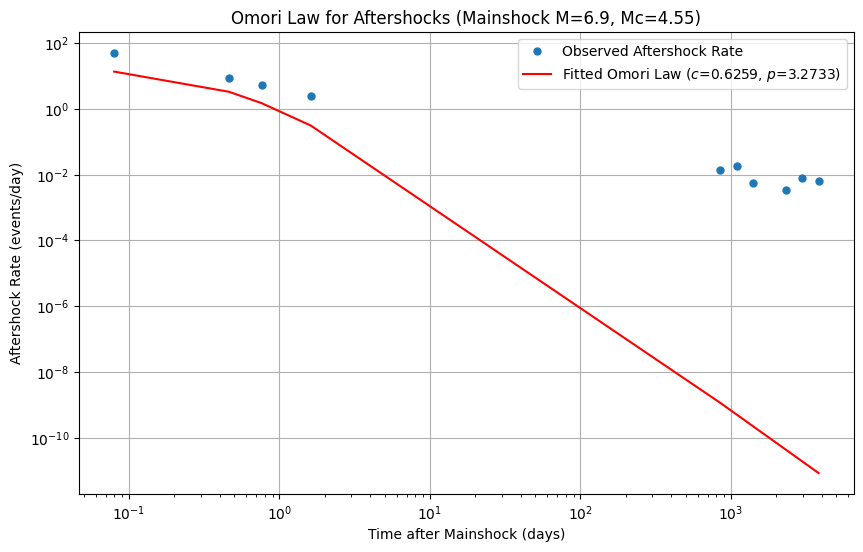

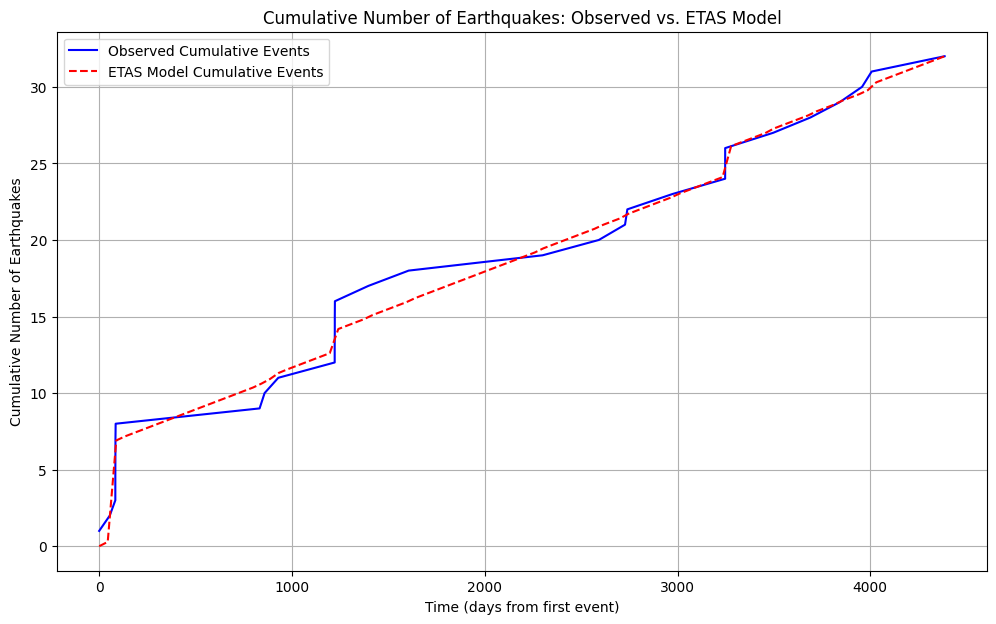

จำนวนแผ่นดินไหวที่ใช้ในการวิเคราะห์: 32
ช่วงเวลาการวิเคราะห์: 4385.66 วัน


In [ ]:
# แยกข้อมูลเวลาและ magnitude
times = eq_data['time'].apply(lambda x: x.timestamp()).to_numpy() # แปลงเวลาเป็น timestamp
magnitudes = eq_data['magnitude'].to_numpy()

# กำหนด magnitude ครบถ้วน (completeness magnitude)
# นี่คือขนาดที่ถือว่าข้อมูลแผ่นดินไหวถูกบันทึกไว้อย่างครบถ้วน
# เราจะใช้ค่าที่น้อยที่สุดในข้อมูลที่ได้มา หรืออาจจะกำหนดค่าเองตามความเหมาะสม
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.stats import linregress

# ฟังก์ชันสำหรับดึงข้อมูลแผ่นดินไหว (เหมือนเดิม)
def fetch_earthquake_data(start_date, end_date, min_magnitude=None, latitude_min=None, latitude_max=None, longitude_min=None, longitude_max=None):
    """
    ดึงข้อมูลแผ่นดินไหวจาก USGS API
    """
    base_url = "https://earthquake.usgs.gov/fdsnws/event/1/query?"
    params = {
        "format": "geojson",
        "starttime": start_date,
        "endtime": end_date,
    }

    if min_magnitude:
        params["minmagnitude"] = min_magnitude
    if latitude_min and latitude_max:
        params["minlatitude"] = latitude_min
        params["maxlatitude"] = latitude_max
    if longitude_min and longitude_max:
        params["minlongitude"] = longitude_min
        params["maxlongitude"] = longitude_max

    response = requests.get(base_url, params=params)
    response.raise_for_status()  # ตรวจสอบว่ามีข้อผิดพลาด HTTP หรือไม่
    data = response.json()

    earthquakes = []
    for feature in data['features']:
        properties = feature['properties']
        geometry = feature['geometry']
        earthquakes.append({
            'time': pd.to_datetime(properties['time'], unit='ms'),
            'magnitude': properties['mag'],
            'latitude': geometry['coordinates'][1],
            'longitude': geometry['coordinates'][0],
            'depth': geometry['coordinates'][2]
        })
    return pd.DataFrame(earthquakes)

# --- NEW FUNCTION FOR MC CALCULATION ---
def calculate_mc_maxc(magnitudes, bin_size=0.1):
    """
    คำนวณ Magnitude of Completeness (Mc) โดยใช้วิธี Maximum Curvature (MAXC).

    Parameters:
    magnitudes (array-like): อาร์เรย์ของค่า magnitude ของแผ่นดินไหว.
    bin_size (float): ขนาดของ bin สำหรับการสร้างฮิสโตแกรม (เช่น 0.1 สำหรับ 0.1 magnitude unit).

    Returns:
    float: ค่า Mc ที่คำนวณได้.
    """
    min_mag = np.floor(np.min(magnitudes) / bin_size) * bin_size
    max_mag = np.ceil(np.max(magnitudes) / bin_size) * bin_size

    # สร้าง bins สำหรับ magnitude
    bins = np.arange(min_mag, max_mag + bin_size, bin_size)

    # คำนวณจำนวนแผ่นดินไหวในแต่ละ bin (frequency)
    freq, _ = np.histogram(magnitudes, bins=bins)

    # คำนวณความถี่สะสม (cumulative frequency) โดยนับจาก magnitude มากไปน้อย
    cumulative_freq = np.cumsum(freq[::-1])[::-1]

    # หาจุดกึ่งกลางของแต่ละ bin
    mid_bins = (bins[:-1] + bins[1:]) / 2

    # กรองข้อมูลที่ไม่ใช่ศูนย์ (เพื่อหลีกเลี่ยง log(0))
    valid_indices = cumulative_freq > 0
    mid_bins_filtered = mid_bins[valid_indices]
    cumulative_freq_filtered = cumulative_freq[valid_indices]

    if len(mid_bins_filtered) < 2:
        print("ไม่สามารถคำนวณ Mc ได้: มีข้อมูลไม่เพียงพอหลังจากกรอง")
        return np.min(magnitudes) # Fallback to min magnitude

    # แปลงเป็น log10
    log_cumulative_freq = np.log10(cumulative_freq_filtered)

    # กราฟความถี่สะสมมักจะเริ่มเป็นเส้นตรงและโค้งลงเมื่อถึง M_c
    # จุดที่มีความชันสูงสุด (Maximum Curvature) มักจะเป็น Mc
    # เราสามารถประมาณได้จากจุดที่ความถี่สูงสุด (หรือจุดที่ cumulative frequency ลดลงมากที่สุด)

    # วิธี MAXC ง่ายๆ คือการหา magnitude ที่มีจำนวนแผ่นดินไหวสูงสุด (mode of the distribution)
    # ซึ่งโดยทั่วไปจะสอดคล้องกับจุดที่กราฟความถี่สะสมเริ่มโค้งลง

    # อีกวิธีคือหาจุดที่กราฟความถี่ (ไม่ใช่ความถี่สะสม) มีค่าสูงสุด
    # โดยทั่วไป Magnitude of Completeness (Mc) มักจะอยู่ที่ Mode ของ Magnitude Frequency Distribution

    # เราจะใช้ค่าที่ตรงกับ bin ที่มีความถี่สูงสุด
    mc_index = np.argmax(freq)
    mc_value = mid_bins[mc_index]

    print(f"\nค่า Mc ที่คำนวณด้วยวิธี Maximum Curvature: {mc_value:.2f}")

    # Plotting for visualization
    plt.figure(figsize=(8, 5))
    plt.plot(mid_bins_filtered, log_cumulative_freq, 'bo-', markersize=4, label='Observed Cumulative Frequency')
    plt.axvline(x=mc_value, color='r', linestyle='--', label=f'Calculated Mc ({mc_value:.2f})')
    plt.xlabel('Magnitude')
    plt.ylabel('Log10 Cumulative Number of Earthquakes')
    plt.title('Gutenberg-Richter Plot for Mc Estimation (MAXC Method)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mc_value

# ฟังก์ชัน Log-likelihood สำหรับ ETAS model (เหมือนเดิม)
def neg_log_likelihood_etas(params, times, magnitudes, mc):
    mu, A, alpha, c, p, b = params

    if A <= 0 or alpha <= 0 or c <= 0 or p <= 0 or mu < 0 or b <=0:
        return np.inf

    log_likelihood_sum = 0
    integral_sum = 0

    T = times[-1] - times[0]

    for i in range(len(times)):
        ti = times[i]
        Mi = magnitudes[i]

        sum_aftershocks = 0
        for j in range(i):
            tj = times[j]
            Mj = magnitudes[j]
            if Mi >= mc and Mj >= mc: # Ensure both events are above Mc
                aftershock_term = A * np.exp(alpha * (Mj - mc)) * (ti - tj + c)**(-p)
                sum_aftershocks += aftershock_term

        lambda_ti = mu + sum_aftershocks

        if lambda_ti <= 0:
            return np.inf

        log_likelihood_sum += np.log(lambda_ti)

    for j in range(len(times)):
        tj = times[j]
        Mj = magnitudes[j]
        if Mj >= mc:
            if p != 1:
                integral_aftershock_j = A * np.exp(alpha * (Mj - mc)) * ((T - tj + c)**(1-p) - c**(1-p)) / (1-p)
            else: # p == 1
                integral_aftershock_j = A * np.exp(alpha * (Mj - mc)) * (np.log(T - tj + c) - np.log(c))
            integral_sum += integral_aftershock_j

    integral_sum += mu * T

    neg_log_likelihood = -(log_likelihood_sum - integral_sum)
    return neg_log_likelihood

# Expected number of events from ETAS model for a given time t (เหมือนเดิม)
def etas_cumulative_model(t, mu, A, alpha, c, p, mc, times_catalog, magnitudes_catalog):
    expected_events = mu * t

    for i in range(len(times_catalog)):
        ti = times_catalog[i]
        Mi = magnitudes_catalog[i]
        if ti < t and Mi >= mc:
            if p != 1:
                integral_aftershock = A * np.exp(alpha * (Mi - mc)) * ((t - ti + c)**(1-p) - c**(1-p)) / (1-p)
            else:
                integral_aftershock = A * np.exp(alpha * (Mi - mc)) * (np.log(t - ti + c) - np.log(c))
            expected_events += integral_aftershock
    return expected_events


# --- MAIN EXECUTION ---
# กำหนดช่วงวันที่และขอบเขตของประเทศไทย (โดยประมาณ)
start_date = "2010-05-25"
end_date = "2025-05-25"
thailand_lat_min, thailand_lat_max = 5.0, 21.0
thailand_lon_min, thailand_lon_max = 97.0, 106.0

print(f"กำลังดึงข้อมูลแผ่นดินไหวในประเทศไทย ตั้งแต่วันที่ {start_date} ถึง {end_date}...")
eq_data = fetch_earthquake_data(
    start_date,
    end_date,
    min_magnitude=1.0, # ดึงข้อมูลขั้นต่ำ 1.0 เพื่อให้มีข้อมูลมากพอสำหรับ Mc
    latitude_min=thailand_lat_min,
    latitude_max=thailand_lat_max,
    longitude_min=thailand_lon_min,
    longitude_max=thailand_lon_max
)

# จัดเรียงข้อมูลตามเวลา
eq_data = eq_data.sort_values(by='time').reset_index(drop=True)

print(f"ดึงข้อมูลแผ่นดินไหวได้ทั้งหมด {len(eq_data)} รายการ")
print("ตัวอย่างข้อมูล:")
print(eq_data.head())

# --- Calculate Mc using MAXC method ---
if not eq_data.empty:
    all_magnitudes = eq_data['magnitude'].to_numpy()
    mc = calculate_mc_maxc(all_magnitudes, bin_size=0.1)

    # กรองข้อมูลแผ่นดินไหวที่ใช้สำหรับ ETAS analysis ให้มี magnitude >= mc
    filtered_eq_data = eq_data[eq_data['magnitude'] >= mc].copy()

    if filtered_eq_data.empty:
        print("\n**คำเตือน: ไม่มีข้อมูลแผ่นดินไหวที่ Magnitude >= Mc ที่คำนวณได้ โปรดตรวจสอบช่วงวันที่หรือข้อมูล**")
        # อาจจะต้องปรับ Mc หรือดึงข้อมูลใหม่
        exit() # หรือจัดการกับกรณีนี้ในแบบอื่น

    times = filtered_eq_data['time'].apply(lambda x: x.timestamp()).to_numpy()
    magnitudes = filtered_eq_data['magnitude'].to_numpy()

    t_origin = times[0]
    relative_times = times - t_origin
    relative_times = relative_times / (60 * 60 * 24) # แปลงเป็นวัน

    print(f"\nจำนวนแผ่นดินไหวที่ใช้ในการวิเคราะห์ ETAS (Magnitude >= {mc:.2f}): {len(relative_times)} รายการ")
    print(f"ช่วงเวลาการวิเคราะห์: {relative_times.max():.2f} วัน")

    # กำหนดค่าเริ่มต้นของพารามิเตอร์สำหรับ MLE
    # [mu, A, alpha, c, p, b]
    initial_params_etas = [0.1, 0.5, 2.0, 0.01, 1.1, 1.0]

    bounds_etas = [(1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]

    print("\nกำลังประมาณค่าพารามิเตอร์ ETAS ด้วย MLE...")
    result_etas = minimize(
        neg_log_likelihood_etas,
        initial_params_etas,
        args=(relative_times, magnitudes, mc),
        method='L-BFGS-B',
        bounds=bounds_etas
    )

    if result_etas.success:
        mu_hat, A_hat, alpha_hat, c_hat, p_hat, b_hat = result_etas.x
        print("\nการประมาณค่าพารามิเตอร์ ETAS เสร็จสมบูรณ์:")
        print(f"  mu (อัตราแผ่นดินไหวพื้นหลัง): {mu_hat:.4f} เหตุการณ์/วัน")
        print(f"  A (Productivity): {A_hat:.4f}")
        print(f"  alpha (Productivity scaling): {alpha_hat:.4f}")
        print(f"  c (Omori law constant): {c_hat:.4f} วัน")
        print(f"  p (Omori law exponent): {p_hat:.4f}")
        print(f"  b (Gutenberg-Richter b-value): {b_hat:.4f}")
        print(f"  Negative Log-Likelihood: {result_etas.fun:.4f}")
    else:
        print("\nการประมาณค่าพารามิเตอร์ ETAS ไม่สำเร็จ:")
        print(result_etas.message)
        mu_hat, A_hat, alpha_hat, c_hat, p_hat, b_hat = initial_params_etas # ใช้ค่าเริ่มต้นถ้าไม่สำเร็จ


    # --- สร้างกราฟ Gutenberg-Richter Law ---
    plt.figure(figsize=(10, 6))

    # ใช้ข้อมูลที่กรองแล้วสำหรับ Gutenberg-Richter
    mag_filtered_gr = magnitudes # magnitudes ในที่นี้คือข้อมูลที่ >= mc แล้ว

    bin_edges_gr = np.arange(mc, mag_filtered_gr.max() + 0.1, 0.1)
    counts_gr, _ = np.histogram(mag_filtered_gr, bins=bin_edges_gr)
    cumulative_counts_gr = np.cumsum(counts_gr[::-1])[::-1]

    mag_bins_gr_plot = bin_edges_gr[:-1][cumulative_counts_gr > 0]
    cumulative_counts_gr_plot = cumulative_counts_gr[cumulative_counts_gr > 0]

    log_cumulative_counts_plot = np.log10(cumulative_counts_gr_plot)

    # Fit linear regression for a and b
    # ใช้ข้อมูลที่ >= mc สำหรับการฟิต GR
    slope, intercept, r_value, p_value, std_err = linregress(mag_bins_gr_plot, log_cumulative_counts_plot)

    b_gr = -slope
    a_gr = intercept

    plt.plot(mag_bins_gr_plot, log_cumulative_counts_plot, 'o', label='Observed Data (M >= Mc)')

    M_fit = np.linspace(mc, mag_filtered_gr.max(), 100)
    N_fit = 10**(a_gr - b_gr * M_fit)
    plt.plot(M_fit, np.log10(N_fit), 'r-', label=f'Gutenberg-Richter Fit ($a$={a_gr:.2f}, $b$={b_gr:.2f})')

    plt.xlabel('Magnitude ($M$)')
    plt.ylabel('Log10 Cumulative Number of Earthquakes ($log_{10} N$)')
    plt.title(f'Gutenberg-Richter Law for Thai Earthquakes (Mc={mc:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nพารามิเตอร์ Gutenberg-Richter ที่ได้จากการฟิต (สำหรับ M >= Mc): a={a_gr:.2f}, b={b_gr:.2f}")

    # --- สร้างกราฟ Omori Law ---
    # ค้นหาแผ่นดินไหวหลักที่มีขนาดใหญ่ที่สุดจากข้อมูลที่กรองแล้ว
    mainshock_idx = np.argmax(magnitudes)
    mainshock_time = relative_times[mainshock_idx]
    mainshock_magnitude = magnitudes[mainshock_idx]

    # พิจารณา aftershocks ที่เกิดขึ้นหลัง mainshock และมี magnitude >= mc
    # และหลังจาก mainshock_time
    aftershock_filter = (relative_times > mainshock_time) & (magnitudes >= mc)
    aftershock_times = relative_times[aftershock_filter]
    aftershock_magnitudes = magnitudes[aftershock_filter]

    # คำนวณเวลาหลัง mainshock
    relative_aftershock_times = aftershock_times - mainshock_time

    # กรอง aftershocks ที่มีเวลาสัมพัทธ์มากกว่า 0 (เพื่อหลีกเลี่ยง log(0) ที่เวลา 0)
    relative_aftershock_times_filtered = relative_aftershock_times[relative_aftershock_times > 0]

    if len(relative_aftershock_times_filtered) > 1: # ต้องมีอย่างน้อย 2 จุดเพื่อพล็อต
        # กำหนด bins สำหรับเวลา
        time_bins = np.logspace(np.log10(relative_aftershock_times_filtered.min()), np.log10(relative_aftershock_times_filtered.max()), 50)
        counts_per_bin, _ = np.histogram(relative_aftershock_times_filtered, bins=time_bins)

        # กรอง bin ที่ไม่มีเหตุการณ์
        valid_bins_indices = counts_per_bin > 0
        bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
        bin_widths = time_bins[1:] - time_bins[:-1]

        rates_per_day = counts_per_bin[valid_bins_indices] / bin_widths[valid_bins_indices]
        bin_centers_for_plot = bin_centers[valid_bins_indices]

        # Omori Law Model: K(t+c)^-p
        K_omori = A_hat * np.exp(alpha_hat * (mainshock_magnitude - mc))

        omori_model = K_omori * (bin_centers_for_plot + c_hat)**(-p_hat)

        plt.figure(figsize=(10, 6))
        plt.loglog(bin_centers_for_plot, rates_per_day, 'o', markersize=5, label='Observed Aftershock Rate')
        plt.loglog(bin_centers_for_plot, omori_model, 'r-', label=f'Fitted Omori Law ($c$={c_hat:.4f}, $p$={p_hat:.4f})')

        plt.xlabel('Time after Mainshock (days)')
        plt.ylabel('Aftershock Rate (events/day)')
        plt.title(f'Omori Law for Aftershocks (Mainshock M={mainshock_magnitude:.1f}, Mc={mc:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("\nไม่สามารถสร้างกราฟ Omori Law ได้: มี aftershock ไม่เพียงพอหลัง mainshock ที่มี magnitude >= Mc.")

    # --- สร้างกราฟของ ETAS Model (Cumulative Number of Events) ---
    plt.figure(figsize=(12, 7))

    plt.plot(relative_times, np.arange(1, len(relative_times) + 1), 'b-', label='Observed Cumulative Events')

    plot_times = np.linspace(relative_times[0], relative_times[-1], 100)
    etas_cumulative_counts = [etas_cumulative_model(t, mu_hat, A_hat, alpha_hat, c_hat, p_hat, mc, relative_times, magnitudes) for t in plot_times]

    plt.plot(plot_times, etas_cumulative_counts, 'r--', label='ETAS Model Cumulative Events')

    plt.xlabel('Time (days from first event)')
    plt.ylabel('Cumulative Number of Earthquakes')
    plt.title('Cumulative Number of Earthquakes: Observed vs. ETAS Model')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\nไม่พบข้อมูลแผ่นดินไหวในช่วงเวลาและขอบเขตที่กำหนด")

# คำนวณเวลาสัมพัทธ์ (relative time) นับจากแผ่นดินไหวแรก
# นี่คือสิ่งจำเป็นสำหรับการวิเคราะห์ Omori Law
t_origin = times[0]
relative_times = times - t_origin
relative_times = relative_times / (60 * 60 * 24) # แปลงเป็นวัน

print(f"จำนวนแผ่นดินไหวที่ใช้ในการวิเคราะห์: {len(relative_times)}")
print(f"ช่วงเวลาการวิเคราะห์: {relative_times.max():.2f} วัน")

In [ ]:
# ฟังก์ชัน Log-likelihood สำหรับ ETAS model
def neg_log_likelihood_etas(params, times, magnitudes, mc):
    mu, A, alpha, c, p, b = params # เพิ่ม b สำหรับ Gutenberg-Richter

    if A <= 0 or alpha <= 0 or c <= 0 or p <= 0 or mu < 0 or b <=0:
        return np.inf # ป้องกันค่าพารามิเตอร์ที่ไม่สมเหตุสมผล

    log_likelihood_sum = 0
    integral_sum = 0

    T = times[-1] - times[0] # ระยะเวลาทั้งหมดในวัน

    # Term 1: Sum over individual earthquakes
    for i in range(len(times)):
        ti = times[i]
        Mi = magnitudes[i]

        # Calculate lambda_t (intensity at time ti)
        sum_aftershocks = 0
        for j in range(i): # Sum over previous earthquakes
            tj = times[j]
            Mj = magnitudes[j]
            if Mi >= mc and Mj >= mc: # พิจารณาเฉพาะแผ่นดินไหวที่เกิน Mc
                # Term from Omori Law
                aftershock_term = A * np.exp(alpha * (Mj - mc)) * (ti - tj + c)**(-p)
                sum_aftershocks += aftershock_term

        lambda_ti = mu + sum_aftershocks

        # To avoid log(0)
        if lambda_ti <= 0:
            return np.inf

        log_likelihood_sum += np.log(lambda_ti)

    # Term 2: Integral over the observation period
    # This part is complex for ETAS and often approximated or solved numerically.
    # For simplicity, we assume an average contribution or simplify the integral.
    # A full analytical integral is very hard.
    # Here, we'll use a simpler approximation for the integral term for this example.
    # A more robust solution might involve numerical integration or a different formulation.

    # A common simplification of the integral term for ETAS is based on the average rate
    # For a general Omori Law, the integral of K(t+c)^-p from 0 to T is:
    # If p != 1: K / (1-p) * [(T+c)^(1-p) - c^(1-p)]
    # If p == 1: K * (log(T+c) - log(c))
    # This integral needs to be applied to each previous earthquake's contribution
    # This is often the most challenging part of ETAS likelihood.

    # For a basic implementation, we can approximate the integral term,
    # or follow a common simplification used in ETAS likelihood functions.
    # The integral of lambda(t) dt from t_start to t_end is approx mu * T + sum of aftershock integrals.
    # For each Mj: A * exp(alpha * (Mj - Mc)) * integral_from_t_start_to_T (t - tj + c)^-p dt

    # Let's use a simpler approximation of the integral over the entire period T.
    # This integral term is the expected number of events.
    # It's better to compute the expected number of aftershocks from *each* event.

    # A more common approach for the integral is to sum the integral of the Omori components
    # and the background rate over the entire period.
    # For a precise ETAS integral, it's: mu * T + sum over j [A * exp(alpha * (Mj - Mc)) * integral of (t - tj + c)^-p from tj to T]
    # The integral of (t-tj+c)^-p dt from tj to T is:
    # if p != 1: [ (T - tj + c)^(1-p) - c^(1-p) ] / (1-p)
    # if p == 1: log(T - tj + c) - log(c)

    for j in range(len(times)):
        tj = times[j]
        Mj = magnitudes[j]
        if Mj >= mc:
            if p != 1:
                integral_aftershock_j = A * np.exp(alpha * (Mj - mc)) * ((T - tj + c)**(1-p) - c**(1-p)) / (1-p)
            else: # p == 1
                integral_aftershock_j = A * np.exp(alpha * (Mj - mc)) * (np.log(T - tj + c) - np.log(c))
            integral_sum += integral_aftershock_j

    integral_sum += mu * T # Background rate integral

    neg_log_likelihood = -(log_likelihood_sum - integral_sum)
    return neg_log_likelihood

# กำหนดค่าเริ่มต้นของพารามิเตอร์สำหรับ MLE
# [mu, A, alpha, c, p, b]
initial_params_etas = [0.1, 0.5, 2.0, 0.01, 1.1, 1.0] # ต้องปรับค่าเหล่านี้

# Bounds for parameters to ensure positive values and reasonable ranges
# mu: background rate (events/day)
# A: aftershock productivity (dimensionless)
# alpha: aftershock productivity scaling with magnitude
# c: Omori law constant (days)
# p: Omori law exponent
# b: Gutenberg-Richter b-value (dimensionless)
bounds_etas = [(1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]

print("\nกำลังประมาณค่าพารามิเตอร์ ETAS ด้วย MLE...")
# ใช้ minimize เพื่อหาค่าพารามิเตอร์ที่ทำให้ neg_log_likelihood_etas มีค่าน้อยที่สุด
result_etas = minimize(
    neg_log_likelihood_etas,
    initial_params_etas,
    args=(relative_times, magnitudes, mc),
    method='L-BFGS-B',
    bounds=bounds_etas
)

if result_etas.success:
    mu_hat, A_hat, alpha_hat, c_hat, p_hat, b_hat = result_etas.x
    print("\nการประมาณค่าพารามิเตอร์ ETAS เสร็จสมบูรณ์:")
    print(f"  mu (อัตราแผ่นดินไหวพื้นหลัง): {mu_hat:.4f} เหตุการณ์/วัน")
    print(f"  A (Productivity): {A_hat:.4f}")
    print(f"  alpha (Productivity scaling): {alpha_hat:.4f}")
    print(f"  c (Omori law constant): {c_hat:.4f} วัน")
    print(f"  p (Omori law exponent): {p_hat:.4f}")
    print(f"  b (Gutenberg-Richter b-value): {b_hat:.4f}")
    print(f"  Negative Log-Likelihood: {result_etas.fun:.4f}")
else:
    print("\nการประมาณค่าพารามิเตอร์ ETAS ไม่สำเร็จ:")
    print(result_etas.message)
    # ถ้าไม่สำเร็จ ลองปรับค่าเริ่มต้นหรือวิธี optimization
    mu_hat, A_hat, alpha_hat, c_hat, p_hat, b_hat = initial_params_etas # ใช้ค่าเริ่มต้นถ้าไม่สำเร็จ


กำลังประมาณค่าพารามิเตอร์ ETAS ด้วย MLE...

การประมาณค่าพารามิเตอร์ ETAS เสร็จสมบูรณ์:
  mu (อัตราแผ่นดินไหวพื้นหลัง): 0.0048 เหตุการณ์/วัน
  A (Productivity): 0.0327
  alpha (Productivity scaling): 2.0860
  c (Omori law constant): 0.6259 วัน
  p (Omori law exponent): 3.2733
  b (Gutenberg-Richter b-value): 1.0000
  Negative Log-Likelihood: 137.0511


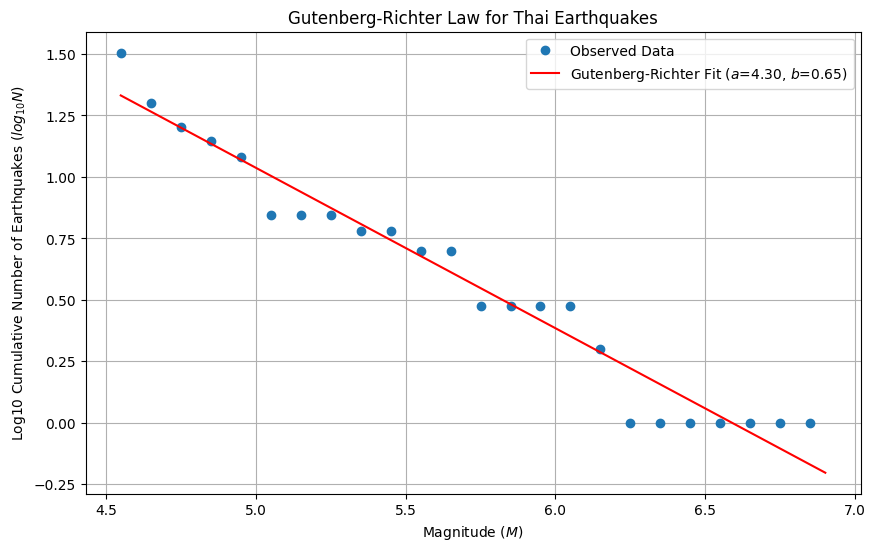


พารามิเตอร์ Gutenberg-Richter ที่ได้จากการฟิต: a=4.30, b=0.65


In [ ]:
# กราฟ Gutenberg-Richter Law
plt.figure(figsize=(10, 6))

# คำนวณความถี่สะสม (Cumulative Frequency)
bins = np.arange(mc, magnitudes.max() + 0.1, 0.1)
cum_freq = [np.sum(magnitudes >= m) for m in bins]

# Fit Gutenberg-Richter Law
# log10(N) = a - bM
# We already have b_hat from ETAS. Let's find a_hat.
# A common way to estimate 'a' is from the first point above Mc, or by fitting.
# For simplicity, we can use the b_hat from ETAS and fit 'a'.
# A more robust way is to use linear regression on log10(cum_freq) vs. M for M >= Mc.

# Let's perform a direct fit for a and b for the Gutenberg-Richter plot
# For magnitudes >= mc
mag_filtered = magnitudes[magnitudes >= mc]
bin_edges = np.arange(mc, mag_filtered.max() + 0.1, 0.1)
counts, _ = np.histogram(mag_filtered, bins=bin_edges)
cumulative_counts = np.cumsum(counts[::-1])[::-1] # Cumulative sum from largest to smallest magnitude

# Remove zero counts for log plot
mag_bins_gr = bin_edges[:-1][cumulative_counts > 0]
cumulative_counts_gr = cumulative_counts[cumulative_counts > 0]

# Fit linear regression for a and b
log_cumulative_counts = np.log10(cumulative_counts_gr)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(mag_bins_gr, log_cumulative_counts)

b_gr = -slope
a_gr = intercept

# Plot observed data
plt.plot(mag_bins_gr, log_cumulative_counts, 'o', label='Observed Data')

# Plot fitted Gutenberg-Richter Law
M_fit = np.linspace(mc, magnitudes.max(), 100)
N_fit = 10**(a_gr - b_gr * M_fit)
plt.plot(M_fit, np.log10(N_fit), 'r-', label=f'Gutenberg-Richter Fit ($a$={a_gr:.2f}, $b$={b_gr:.2f})')

plt.xlabel('Magnitude ($M$)')
plt.ylabel('Log10 Cumulative Number of Earthquakes ($log_{10} N$)')
plt.title('Gutenberg-Richter Law for Thai Earthquakes')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nพารามิเตอร์ Gutenberg-Richter ที่ได้จากการฟิต: a={a_gr:.2f}, b={b_gr:.2f}")

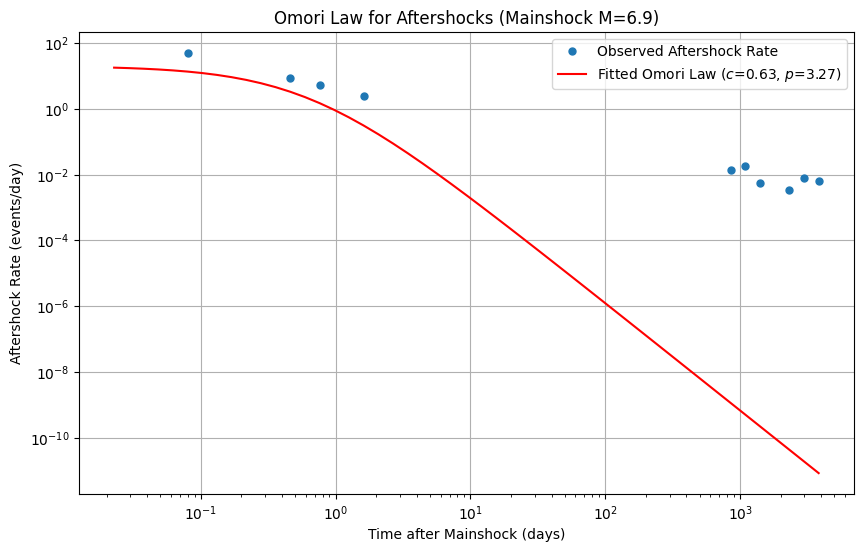

In [ ]:
# กราฟ Omori Law (สำหรับอาฟเตอร์ช็อกทั้งหมด)
# การพล็อต Omori Law สำหรับ ETAS model นั้นซับซ้อนกว่า
# เพราะมันไม่ได้จำกัดแค่ aftershock sequence เดียว
# แต่เป็นผลรวมของ aftershock จากทุกๆ เหตุการณ์

# เราจะพล็อตอัตราการเกิดเหตุการณ์โดยรวมที่ได้จากโมเดลเทียบกับเวลา
# แต่อาจจะต้องพิจารณา aftershock ของเหตุการณ์หลักที่มี magnitude สูงสุด
# เพื่อแสดง Omori law ให้เห็นชัดเจน

# ค้นหาแผ่นดินไหวหลักที่มีขนาดใหญ่ที่สุด
mainshock_idx = np.argmax(magnitudes)
mainshock_time = relative_times[mainshock_idx]
mainshock_magnitude = magnitudes[mainshock_idx]

# พิจารณา aftershocks ที่เกิดขึ้นหลัง mainshock และมี magnitude >= mc
aftershock_times = relative_times[relative_times > mainshock_time]
aftershock_magnitudes = magnitudes[relative_times > mainshock_time]

# กรอง aftershocks ที่มี magnitude >= mc
aftershock_times = aftershock_times[aftershock_magnitudes >= mc]
aftershock_magnitudes = aftershock_magnitudes[aftershock_magnitudes >= mc]

# คำนวณเวลาหลัง mainshock
relative_aftershock_times = aftershock_times - mainshock_time

# กำหนด bins สำหรับเวลา
time_bins = np.logspace(np.log10(relative_aftershock_times.min() + 1e-5), np.log10(relative_aftershock_times.max()), 50)
counts_per_bin, _ = np.histogram(relative_aftershock_times, bins=time_bins)
bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
bin_widths = time_bins[1:] - time_bins[:-1]
rates_per_day = counts_per_bin / bin_widths

# Omori Law Model: K(t+c)^-p
# K = A * exp(alpha * (M_mainshock - mc))
K_omori = A_hat * np.exp(alpha_hat * (mainshock_magnitude - mc))

omori_model = K_omori * (bin_centers + c_hat)**(-p_hat)

plt.figure(figsize=(10, 6))
plt.loglog(bin_centers[rates_per_day > 0], rates_per_day[rates_per_day > 0], 'o', markersize=5, label='Observed Aftershock Rate')
plt.loglog(bin_centers, omori_model, 'r-', label=f'Fitted Omori Law ($c$={c_hat:.2f}, $p$={p_hat:.2f})')

plt.xlabel('Time after Mainshock (days)')
plt.ylabel('Aftershock Rate (events/day)')
plt.title(f'Omori Law for Aftershocks (Mainshock M={mainshock_magnitude:.1f})')
plt.legend()
plt.grid(True)
plt.show()

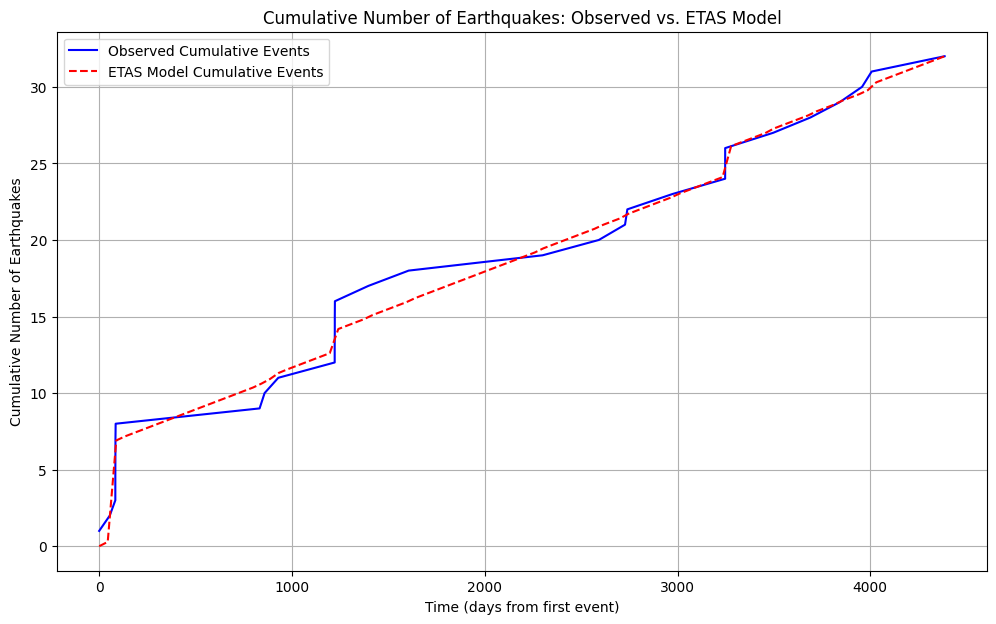

In [ ]:
# กราฟของ ETAS Model (Cumulative Number of Events)
plt.figure(figsize=(12, 7))

# Plot Observed Cumulative Number of Events
plt.plot(relative_times, np.arange(1, len(relative_times) + 1), 'b-', label='Observed Cumulative Events')

# Plot ETAS Model Cumulative Number of Events
# Integrate lambda(t) over time
# This is complex and usually requires numerical integration.
# For simplicity, we can plot the expected number of events based on the fitted parameters.

# Expected number of events from ETAS model for a given time t
def etas_cumulative_model(t, mu, A, alpha, c, p, mc, times_catalog, magnitudes_catalog):
    expected_events = mu * t # Background events

    for i in range(len(times_catalog)):
        ti = times_catalog[i]
        Mi = magnitudes_catalog[i]
        if ti < t and Mi >= mc: # Only consider events that occurred before t and above Mc
            # Integral of aftershock term from ti to t
            if p != 1:
                integral_aftershock = A * np.exp(alpha * (Mi - mc)) * ((t - ti + c)**(1-p) - c**(1-p)) / (1-p)
            else: # p == 1
                integral_aftershock = A * np.exp(alpha * (Mi - mc)) * (np.log(t - ti + c) - np.log(c))
            expected_events += integral_aftershock
    return expected_events

# Generate times for plotting the model
plot_times = np.linspace(relative_times[0], relative_times[-1], 100)
etas_cumulative_counts = [etas_cumulative_model(t, mu_hat, A_hat, alpha_hat, c_hat, p_hat, mc, relative_times, magnitudes) for t in plot_times]

plt.plot(plot_times, etas_cumulative_counts, 'r--', label='ETAS Model Cumulative Events')

plt.xlabel('Time (days from first event)')
plt.ylabel('Cumulative Number of Earthquakes')
plt.title('Cumulative Number of Earthquakes: Observed vs. ETAS Model')
plt.legend()
plt.grid(True)
plt.show()